In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import torch
from torch.nn.functional import grid_sample

In [2]:
# define support functions from STalign

def transform_image_source_with_A(A, XI, I, XJ, dir='s2t'):
    '''
    Transform an image with an affine matrix
    
    Parameters
    ----------
    
    A  : torch tensor
         Affine transform matrix
        
    XI : list of numpy arrays
         List of arrays storing the pixel location in image I along each image axis. 
         convention is row column order not xy. i.e, 
         locations of pixels along the y axis (rows) followed by
         locations of pixels along the x axis (columns)  
    
    I  : numpy array
         A rasterized image with len(blur) channels along the first axis
        
    XJ : list of numpy arrays
         List of arrays storing the pixel location in image I along each image axis. 
         convention is row column order not xy. i.e, 
         locations of pixels along the y axis (rows) followed by
         locations of pixels along the x axis (columns)         
    
    Returns
    -------
    AI : torch tensor
        image I after affine transformation A, with channels along first axis
              
    '''
    xv = None
    v = None

    if dir not in ('t2s', 's2t'):
        raise Exception('an excepted direction has not been given')
    
    if dir == 's2t':
        AI= transform_image_source_to_target(xv, v, A, XI, I, XJ=XJ)

    if dir == 't2s':
        AI= transform_image_target_to_source(xv, v, A, XJ, I, XI=XI)
    
    return AI


def transform_image_source_to_target(xv,v,A,xI,I,XJ=None):
    '''
    Transform an image
    '''
    phii = build_transform(xv,v,A,direction='b',XJ=XJ)    
    phiI = interp(xI,I,phii.permute(2,0,1),padding_mode="border")
    return phiI
    
    
def transform_image_target_to_source(xv,v,A,xJ,J,XI=None):
    '''
    Transform an image
    '''
    phi = build_transform(xv,v,A,direction='f',XJ=XI)    
    phiiJ = interp(xJ,J,phi.permute(2,0,1),padding_mode="border")
    return phiiJ


def build_transform(xv,v,A,direction='b',XJ=None):
    ''' Create sample points to transform source to target from affine and velocity.
    
    Parameters
    ----------
    xv : list of array
        Sample points for velocity
    v : array
        time dependent velocity field
    A : array
        Affine transformation matrix
    direction : char
        'f' for forward and 'b' for backward. 'b' is default and is used for transforming images.
        'f' is used for transforming points.
    XJ : array
        Sample points for target (meshgrid with ij index style).  Defaults to None 
        to keep sampling on the xv.
    
    Returns
    -------
    Xs : array
        Sample points in mehsgrid format.
    
    
    '''
    
    A = torch.tensor(A)
    if v is not None: v = torch.tensor(v) 
    if XJ is not None:
        # check some types here
        if isinstance(XJ,list):
            if XJ[0].ndim == 1: # need meshgrid
                XJ = torch.stack(torch.meshgrid([torch.tensor(x) for x in XJ],indexing='ij'),-1)
            elif XJ[0].ndim == 2: # assume already meshgrid
                XJ = torch.stack([torch.tensor(x) for x in XJ],-1)
            else:
                raise Exception('Could not understand variable XJ type')
            
        # if it is already in meshgrid form we just need to make sure it is a tensor
        XJ = torch.tensor(XJ)
    else:
        XJ = torch.stack(torch.meshgrid([torch.tensor(x) for x in xv],indexing='ij'),-1)
        
    if direction == 'b':
        Ai = torch.linalg.inv(A)
        # transform sample points
        Xs = (Ai[:-1,:-1]@XJ[...,None])[...,0] + Ai[:-1,-1]    
        # now diffeo, not semilagrange here
        if v is not None:
            nt = v.shape[0]
            for t in range(nt-1,-1,-1):
                Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
    elif direction == 'f':
        Xs = torch.clone(XJ)
        if v is not None:
            nt = v.shape[0]
            for t in range(nt):
                Xs = Xs + interp(xv,v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
        Xs = (A[:2,:2]@Xs[...,None])[...,0] + A[:2,-1]    
            
    else:
        raise Exception(f'Direction must be "f" or "b" but you input {direction}')
    return Xs 
    
def interp(x,I,phii,**kwargs):
    '''
    Interpolate the 2D image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (3D arrays with first channel storing component)    
    
    Parameters
    ----------
    x : list of arrays
        List of arrays storing the pixel locations along each image axis. convention is row column order not xy.
    I : array
        Image array. First axis should contain different channels.
    phii : array
        Sampling array. First axis should contain sample locations corresponding to each axis.
    **kwargs : dict
        Other arguments fed into the torch interpolation function torch.nn.grid_sample
        
    
    Returns
    -------
    out : torch tensor
            The image I resampled on the points defined in phii.
    
    Notes
    -----
    Convention is to use align_corners=True.
    
    This uses the torch library.
    '''
    
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(2):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]

def L_T_from_points(pointsI,pointsJ):
    '''
    Compute an affine transformation from points.
    
    Note for an affine transformation (6dof) we need 3 points.
    
    Outputs, L,T should be rconstructed blockwize like [L,T;0,0,1]
    
    Parameters
    ----------
    pointsI : array
        An Nx2 array of floating point numbers describing source points in ROW COL order (not xy)
    pointsJ : array
        An Nx2 array of floating point numbers describing target points in ROW COL order (not xy)
    
    Returns
    -------
    L : array
        A 2x2 linear transform array.
    T : array
        A 2 element translation vector
    '''
    if pointsI is None or pointsJ is None:
        raise Exception('Points are set to None')
        
    nI = pointsI.shape[0]
    nJ = pointsJ.shape[0]
    if nI != nJ:
        raise Exception(f'Number of pointsI ({nI}) is not equal to number of pointsJ ({nJ})')
    if pointsI.shape[1] != 2:
        raise Exception(f'Number of components of pointsI ({pointsI.shape[1]}) should be 2')
    if pointsJ.shape[1] != 2:
        raise Exception(f'Number of components of pointsJ ({pointsJ.shape[1]}) should be 2')
    # transformation model
    if nI < 3:
        # translation only 
        L = np.eye(2)
        T = np.mean(pointsJ,0) - np.mean(pointsI,0)
    else:
        # we need an affine transform
        pointsI_ = np.concatenate((pointsI,np.ones((nI,1))),1)
        pointsJ_ = np.concatenate((pointsJ,np.ones((nI,1))),1)
        II = pointsI_.T@pointsI_
        IJ = pointsI_.T@pointsJ_
        A = (np.linalg.inv(II)@IJ).T        
        L = A[:2,:2]
        T = A[:2,-1]
    return L,T

def to_A(L,T):
    ''' Convert a linear transform matrix and a translation vector into an affine matrix.
    
    Parameters
    ----------
    L : torch tensor
        2x2 linear transform matrix
        
    T : torch tensor
        2 element translation vector (note NOT 2x1)
        
    Returns
    -------
    
    A : torch tensor
        Affine transform matrix
        
        
    '''
    O = torch.tensor([0.,0.,1.],device=L.device,dtype=L.dtype)
    A = torch.cat((torch.cat((L,T[:,None]),1),O[None]))
    return A

In [3]:
# Configure global matplotlib settings for dark theme
plt.rcParams.update({
    'figure.facecolor': 'black',         # Figure background color
    'axes.facecolor': 'black',           # Axes background color
    'axes.edgecolor': 'white',           # Axes edge color
    'axes.labelcolor': 'white',          # Axis label color
    'xtick.color': 'white',              # X-axis tick color
    'ytick.color': 'white',              # Y-axis tick color
    'text.color': 'white',               # Text color
    'axes.titlecolor': 'white',          # Title color
    'savefig.facecolor': 'black',        # Saved figure background color
    'savefig.edgecolor': 'black'         # Saved figure edge color
})

Text(0.5, 1.0, 'Bitmap Exported')

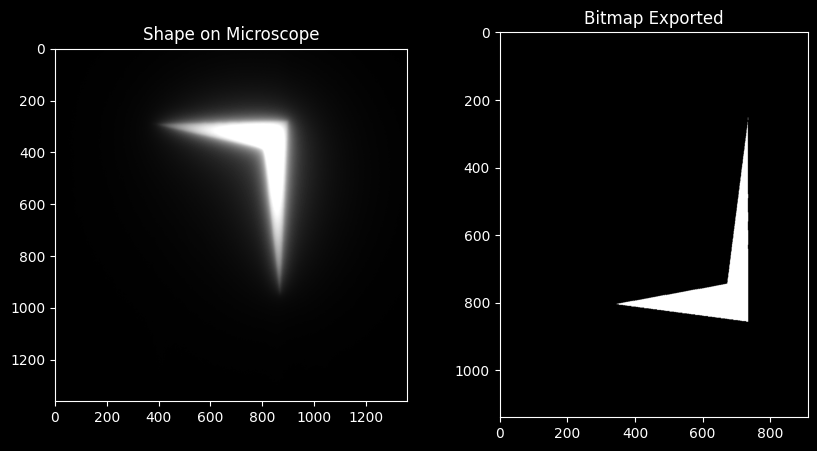

In [4]:
tri_1 = plt.imread('../03_patterns/20240913_DMD_patterns_export/20240919-Calibration/triangle_1.tif')
tri_1_bmp = plt.imread('../03_patterns/20240913_DMD_patterns_export/20240919-Calibration/triangle_1.bmp')

fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))
ax1.imshow(tri_1, cmap='grey')
ax1.set_aspect('equal')
ax1.set_title('Shape on Microscope')
ax2.imshow(tri_1_bmp, cmap='grey')
ax2.set_aspect('equal')
ax2.set_title('Bitmap Exported')

In [5]:
print(tri_1_bmp.shape)

(1140, 912)


In [6]:
def normalize(arr, t_min=0, t_max=1):
    """Linearly normalizes an array between two specifed values.
    
    Parameters
    ----------
    arr : numpy array
        array to be normalized
    t_min : int or float
        Lower bound of normalization range
    t_max : int or float
        Upper bound of normalization range
    
    Returns
    -------
    norm_arr : numpy array
        1D array with normalized arr values
        
    """
    
    diff = t_max - t_min
    diff_arr = np.max(arr) - np.min(arr)
    min_ = np.min(arr)
        
    norm_arr = ((arr - min_)/diff_arr * diff) + t_min
    
    return norm_arr


In [7]:
tri_1_norm = normalize(tri_1)
tri_1_bmp_norm = normalize(tri_1_bmp)

I = np.expand_dims(tri_1_norm, axis=0)
J = np.expand_dims(tri_1_bmp_norm, axis=0)

print(I.shape)
print(J.shape)

(1, 1360, 1360)
(1, 1140, 912)


In [8]:
YI = np.array(range(I.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.

# get extent of images


def extent_from_x(xJ):
    ''' Given a set of pixel locations, returns an extent 4-tuple for use with np.imshow.
    
    Note inputs are locations of pixels along each axis, i.e. row column not xy.
    
    Parameters
    ----------
    xJ : list of torch tensors
        Location of pixels along each axis
    
    Returns
    -------
    extent : tuple
        (xmin, xmax, ymin, ymax) tuple
    
    Examples
    --------
    
    >>> extent_from_x(xJ)
    >>> fig,ax = plt.subplots()
    >>> ax.imshow(J,extent=extentJ)
    
    '''
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = ( (xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    return extentJ


extentJ = extent_from_x((YJ,XJ))
extentI = extent_from_x((YI,XI))

In [9]:
np.savez('camera.npz', x=XI, y= YI, I=I)
np.savez('bitmap.npz', x= XJ, y= YJ, I=J)


### Use the point annotator from STalign to annotate common points between .bmp and camera image

- to use point annotator follow this instruction: https://www.youtube.com/watch?v=qZLhAGKPxGM , at ~ 4 min

In [10]:
# read from file
pointsIlist = np.load('camera_points.npy', allow_pickle=True).tolist()
print(pointsIlist)
pointsJlist = np.load('bitmap_points.npy', allow_pickle=True).tolist()
print(pointsJlist)


{'point': [(385.2711540347093, 293.9244206948392), (901.5884400431415, 278.2784423309474), (866.3849887243849, 935.4095336144068), (799.8895806778443, 391.7117854691637)]}
{'point': [(732.3489459750961, 250.6085008334153), (732.3489459750961, 853.8990195117169), (344.1446122168843, 804.0619766643789), (672.0198941072656, 741.1099225414257)]}


In [11]:
# convert to array
pointsI = []
pointsJ = []

for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        pointsI.append([pointsIlist[i][j][1], pointsIlist[i][j][0]])
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        pointsJ.append([pointsJlist[i][j][1], pointsJlist[i][j][0]])

pointsI = np.array(pointsI)
pointsJ = np.array(pointsJ)

print(pointsI)
print(pointsJ)

[[293.92442069 385.27115403]
 [278.27844233 901.58844004]
 [935.40953361 866.38498872]
 [391.71178547 799.88958068]]
[[250.60850083 732.34894598]
 [853.89901951 732.34894598]
 [804.06197666 344.14461222]
 [741.10992254 672.01989411]]


Text(0.5, 1.0, 'target with pointsJ')

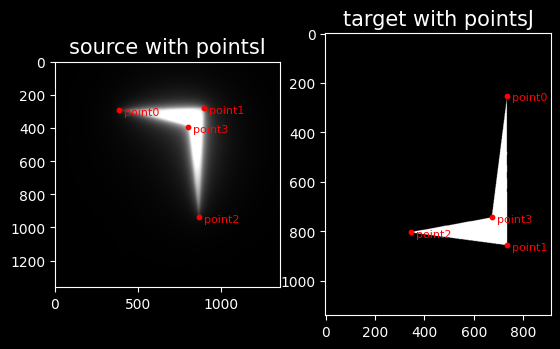

In [12]:
# plot

fig,ax = plt.subplots(1,2)
ax[0].imshow((I.transpose(1,2,0).squeeze()),cmap='grey')
ax[1].imshow((J.transpose(1,2,0).squeeze()),cmap='grey')

trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')

ax[0].scatter(pointsI[:,1],pointsI[:,0], c='red', s=10)
ax[1].scatter(pointsJ[:,1],pointsJ[:,0], c='red', s=10)

for i in pointsIlist.keys():
    for j in range(len(pointsIlist[i])):
        ax[0].text(pointsIlist[i][j][0], pointsIlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_0, fontsize= 8)
for i in pointsJlist.keys():
    for j in range(len(pointsJlist[i])):
        ax[1].text(pointsJlist[i][j][0], pointsJlist[i][j][1],f'{i}{j}', c='red', transform=trans_offset_1, fontsize= 8)

ax[0].set_title('source with pointsI', fontsize=15)
ax[1].set_title('target with pointsJ', fontsize=15)

# invert only rasterized image
# ax[0].invert_yaxis()

In [13]:
def transform_image_source_with_A(A, XI, I, XJ, dir='s2t'):
    '''
    Transform an image with an affine matrix
    
    Parameters
    ----------
    
    A  : torch tensor
         Affine transform matrix
        
    XI : list of numpy arrays
         List of arrays storing the pixel location in image I along each image axis. 
         convention is row column order not xy. i.e, 
         locations of pixels along the y axis (rows) followed by
         locations of pixels along the x axis (columns)  
    
    I  : numpy array
         A rasterized image with len(blur) channels along the first axis
        
    XJ : list of numpy arrays
         List of arrays storing the pixel location in image I along each image axis. 
         convention is row column order not xy. i.e, 
         locations of pixels along the y axis (rows) followed by
         locations of pixels along the x axis (columns)         
    
    Returns
    -------
    AI : torch tensor
        image I after affine transformation A, with channels along first axis
              
    '''
    xv = None
    v = None

    if dir not in ('t2s', 's2t'):
        raise Exception('an excepted direction has not been given')
    
    if dir == 's2t':
        AI= transform_image_source_to_target(xv, v, A, XI, I, XJ=XJ)

    if dir == 't2s':
        AI= transform_image_target_to_source(xv, v, A, XJ, I, XI=XI)
    
    return AI


def transform_image_source_to_target(xv,v,A,xI,I,XJ=None):
    '''
    Transform an image
    '''
    phii = build_transform(xv,v,A,direction='b',XJ=XJ)    
    phiI = interp(xI,I,phii.permute(2,0,1),padding_mode="border")
    return phiI
    
    
def transform_image_target_to_source(xv,v,A,xJ,J,XI=None):
    '''
    Transform an image
    '''
    phi = build_transform(xv,v,A,direction='f',XJ=XI)    
    phiiJ = interp(xJ,J,phi.permute(2,0,1),padding_mode="border")
    return phiiJ


def build_transform(xv,v,A,direction='b',XJ=None):
    ''' Create sample points to transform source to target from affine and velocity.
    
    Parameters
    ----------
    xv : list of array
        Sample points for velocity
    v : array
        time dependent velocity field
    A : array
        Affine transformation matrix
    direction : char
        'f' for forward and 'b' for backward. 'b' is default and is used for transforming images.
        'f' is used for transforming points.
    XJ : array
        Sample points for target (meshgrid with ij index style).  Defaults to None 
        to keep sampling on the xv.
    
    Returns
    -------
    Xs : array
        Sample points in mehsgrid format.
    
    
    '''
    
    A = torch.tensor(A)
    if v is not None: v = torch.tensor(v) 
    if XJ is not None:
        # check some types here
        if isinstance(XJ,list):
            if XJ[0].ndim == 1: # need meshgrid
                XJ = torch.stack(torch.meshgrid([torch.tensor(x) for x in XJ],indexing='ij'),-1)
            elif XJ[0].ndim == 2: # assume already meshgrid
                XJ = torch.stack([torch.tensor(x) for x in XJ],-1)
            else:
                raise Exception('Could not understand variable XJ type')
            
        # if it is already in meshgrid form we just need to make sure it is a tensor
        XJ = torch.tensor(XJ)
    else:
        XJ = torch.stack(torch.meshgrid([torch.tensor(x) for x in xv],indexing='ij'),-1)
        
    if direction == 'b':
        Ai = torch.linalg.inv(A)
        # transform sample points
        Xs = (Ai[:-1,:-1]@XJ[...,None])[...,0] + Ai[:-1,-1]    
        # now diffeo, not semilagrange here
        if v is not None:
            nt = v.shape[0]
            for t in range(nt-1,-1,-1):
                Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
    elif direction == 'f':
        Xs = torch.clone(XJ)
        if v is not None:
            nt = v.shape[0]
            for t in range(nt):
                Xs = Xs + interp(xv,v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
        Xs = (A[:2,:2]@Xs[...,None])[...,0] + A[:2,-1]    
            
    else:
        raise Exception(f'Direction must be "f" or "b" but you input {direction}')
    return Xs 
    
def interp(x,I,phii,**kwargs):
    '''
    Interpolate the 2D image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (3D arrays with first channel storing component)    
    
    Parameters
    ----------
    x : list of arrays
        List of arrays storing the pixel locations along each image axis. convention is row column order not xy.
    I : array
        Image array. First axis should contain different channels.
    phii : array
        Sampling array. First axis should contain sample locations corresponding to each axis.
    **kwargs : dict
        Other arguments fed into the torch interpolation function torch.nn.grid_sample
        
    
    Returns
    -------
    out : torch tensor
            The image I resampled on the points defined in phii.
    
    Notes
    -----
    Convention is to use align_corners=True.
    
    This uses the torch library.
    '''
    
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(2):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]

def L_T_from_points(pointsI,pointsJ):
    '''
    Compute an affine transformation from points.
    
    Note for an affine transformation (6dof) we need 3 points.
    
    Outputs, L,T should be rconstructed blockwize like [L,T;0,0,1]
    
    Parameters
    ----------
    pointsI : array
        An Nx2 array of floating point numbers describing source points in ROW COL order (not xy)
    pointsJ : array
        An Nx2 array of floating point numbers describing target points in ROW COL order (not xy)
    
    Returns
    -------
    L : array
        A 2x2 linear transform array.
    T : array
        A 2 element translation vector
    '''
    if pointsI is None or pointsJ is None:
        raise Exception('Points are set to None')
        
    nI = pointsI.shape[0]
    nJ = pointsJ.shape[0]
    if nI != nJ:
        raise Exception(f'Number of pointsI ({nI}) is not equal to number of pointsJ ({nJ})')
    if pointsI.shape[1] != 2:
        raise Exception(f'Number of components of pointsI ({pointsI.shape[1]}) should be 2')
    if pointsJ.shape[1] != 2:
        raise Exception(f'Number of components of pointsJ ({pointsJ.shape[1]}) should be 2')
    # transformation model
    if nI < 3:
        # translation only 
        L = np.eye(2)
        T = np.mean(pointsJ,0) - np.mean(pointsI,0)
    else:
        # we need an affine transform
        pointsI_ = np.concatenate((pointsI,np.ones((nI,1))),1)
        pointsJ_ = np.concatenate((pointsJ,np.ones((nI,1))),1)
        II = pointsI_.T@pointsI_
        IJ = pointsI_.T@pointsJ_
        A = (np.linalg.inv(II)@IJ).T        
        L = A[:2,:2]
        T = A[:2,-1]
    return L,T

def to_A(L,T):
    ''' Convert a linear transform matrix and a translation vector into an affine matrix.
    
    Parameters
    ----------
    L : torch tensor
        2x2 linear transform matrix
        
    T : torch tensor
        2 element translation vector (note NOT 2x1)
        
    Returns
    -------
    
    A : torch tensor
        Affine transform matrix
        
        
    '''
    O = torch.tensor([0.,0.,1.],device=L.device,dtype=L.dtype)
    A = torch.cat((torch.cat((L,T[:,None]),1),O[None]))
    return A

L, T = L_T_from_points(pointsI,pointsJ)
A = to_A(torch.tensor(L),torch.tensor(T))

In [ ]:
A

tensor([[-1.6718e-02,  1.1725e+00, -1.9525e+02],
        [-5.9400e-01, -1.5005e-02,  9.1334e+02],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], dtype=torch.float64)

In [16]:
torch.save(A, '20241104_1360x1360_to_DMD.pt')

C:\Users\Jerro\AppData\Local\Temp\ipykernel_30128\1571862493.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
C:\Users\Jerro\AppData\Local\Temp\ipykernel_30128\1571862493.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


Text(0.5, 1.0, 'target')

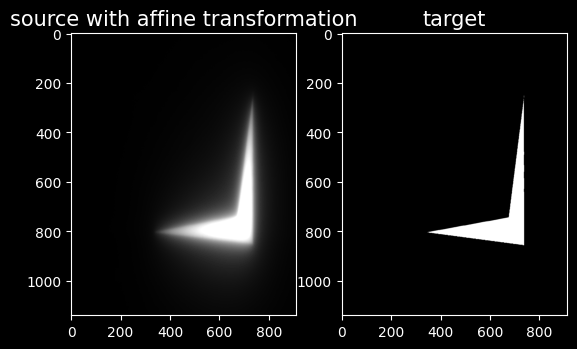

In [18]:
# compute initial affine transformation from points
AI= transform_image_source_with_A(A, [YI,XI], I, [YJ,XJ])

#switch tensor from cuda to cpu for plotting with numpy
if AI.is_cuda:
    AI = AI.cpu()

fig,ax = plt.subplots(1,2)

ax[0].imshow((AI.permute(1,2,0).squeeze()), extent=extentJ, cmap='grey')
ax[1].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ, cmap='grey')

ax[0].set_title('source with affine transformation', fontsize=15)
ax[1].set_title('target', fontsize=15)

C:\Users\Jerro\AppData\Local\Temp\ipykernel_30128\1571862493.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
C:\Users\Jerro\AppData\Local\Temp\ipykernel_30128\1571862493.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


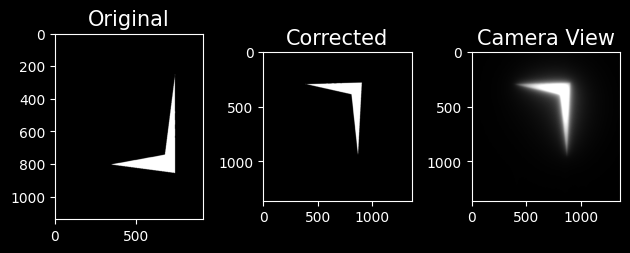

In [19]:
# compute initial affine transformation from points
AJ= transform_image_source_with_A(A, [YI,XI], J, [YJ,XJ], dir='t2s')

#switch tensor from cuda to cpu for plotting with numpy
if AJ.is_cuda:
    AJ = AJ.cpu()

fig,ax = plt.subplots(1,3)

ax[0].imshow((J.transpose(1,2,0).squeeze()), extent=extentJ, cmap='grey')
ax[1].imshow((AJ.permute(1,2,0).squeeze()), extent=extentI, cmap='grey')
ax[2].imshow((I.transpose(1,2,0).squeeze()), extent=extentI, cmap='grey')

ax[0].set_title('Original', fontsize=15)
ax[1].set_title('Corrected', fontsize=15)
ax[2].set_title('Camera View', fontsize=15)


ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')

fig.tight_layout()

### Try on an image

(365, 394, 3)


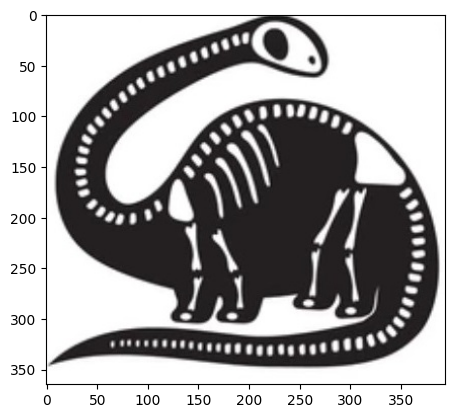

In [118]:
img = plt.imread("diplodocus-silo.jpg")
plt.imshow(img)
print(img.shape)

In [119]:
def rgb_to_grayscale(rgb_image):
    # Use the weighted sum to convert to grayscale
    grayscale_image = 0.2989 * rgb_image[:, :, 0] + 0.5870 * rgb_image[:, :, 1] + 0.1140 * rgb_image[:, :, 2]
    
    return grayscale_image

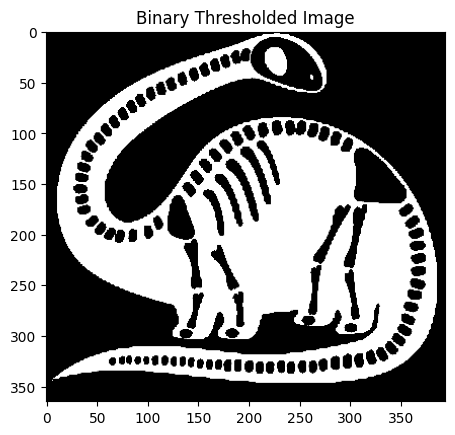

In [120]:
# Convert the binary image to a supported type (float32)
binary_img = (img < 50).astype(np.float32)

gray_img = rgb_to_grayscale(binary_img)

# Plot the binary thresholded image
plt.imshow(gray_img, cmap='gray')
plt.title('Binary Thresholded Image')
plt.show()

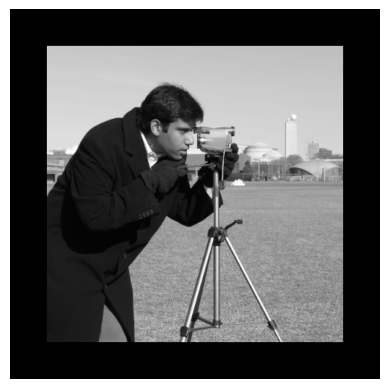

In [121]:
import numpy as np
from skimage.transform import rescale
from skimage import img_as_ubyte

def place_image_on_canvas(image, canvas_size, position="center", scale=1.0):
    """
    Places the given 2D grayscale image on a blank canvas of defined size, with optional scaling and positioning.
    
    Parameters:
    -----------
    image : np.ndarray
        The input 2D grayscale image to be placed on the canvas (height, width).
        
    canvas_size : tuple
        The size of the canvas as (height, width).
    
    position : str or tuple, default "center"
        Position to place the image on the canvas. Can be "center" or a tuple (x, y) for 
        the top-left corner of the image.
    
    scale : float, default 1.0
        The scaling factor for resizing the image.
        
    Returns:
    --------
    canvas : np.ndarray
        The resulting canvas with the image placed according to the specified parameters.
    """
    
    # Rescale the image using skimage's rescale function
    scaled_image = rescale(image, scale, anti_aliasing=True)
    scaled_image = img_as_ubyte(scaled_image)  # Convert to uint8
    
    # Get dimensions of the scaled image (2D)
    scaled_height, scaled_width = scaled_image.shape
    
    # Create a blank canvas (all zeros) with the same size as specified
    canvas = np.zeros((canvas_size[0], canvas_size[1]), dtype=np.uint8)
    
    # Determine the position to place the image
    if position == "center":
        # Calculate the top-left corner for centering
        start_y = (canvas_size[0] - scaled_height) // 2
        start_x = (canvas_size[1] - scaled_width) // 2
    elif isinstance(position, tuple):
        # Use the provided top-left corner position
        start_x, start_y = position
    else:
        raise ValueError("Invalid position argument. Use 'center' or a tuple (x, y).")
    
    # Ensure the image fits within the canvas
    end_y = min(start_y + scaled_height, canvas_size[0])
    end_x = min(start_x + scaled_width, canvas_size[1])
    
    # Calculate the regions to place the image on the canvas
    canvas[start_y:end_y, start_x:end_x] = scaled_image[:(end_y-start_y), :(end_x-start_x)]
    
    return canvas

import matplotlib.pyplot as plt
from skimage import data

# Example 2D grayscale image
grayscale_image = data.camera()  # Use skimage's built-in grayscale image

# Canvas size (larger than the image)
canvas_size = (512, 512)

# Place the image on the canvas, scaled by 0.8, centered
canvas = place_image_on_canvas(grayscale_image, canvas_size, position="center", scale=0.8)

# Display the resulting canvas
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.show()



(365, 394)
(1, 1360, 1360)


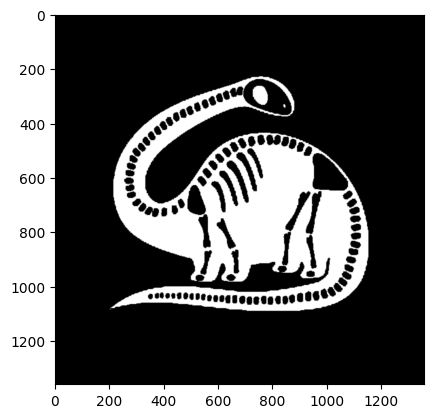

In [122]:
canvas_size = (1360,1360)
print(gray_img.shape)
canvas = place_image_on_canvas(gray_img, canvas_size, position="center", scale=2.5)


canvas = normalize(canvas)

canvas = np.expand_dims(canvas, axis=0)
print(canvas.shape)
# print(canvas.transpose(2,1,0).shape)
# Display the result
plt.imshow(canvas.transpose(1,2,0),cmap='gray')
# plt.axis('off')
plt.show()


In [123]:
YI = np.array(range(canvas.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(canvas.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.

# get extent of ima


extentJ = extent_from_x((YJ,XJ))
extentI = extent_from_x((YI,XI))

C:\Users\jerry\AppData\Local\Temp\ipykernel_8976\1571862493.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
C:\Users\jerry\AppData\Local\Temp\ipykernel_8976\1571862493.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


Text(0.5, 1.0, 'Deformed')

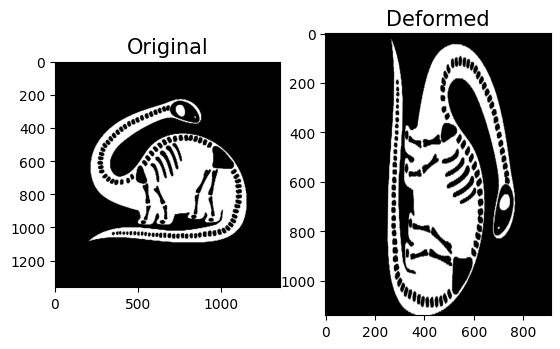

In [124]:
# compute initial affine transformation from points
AI= transform_image_source_with_A(A, [YI,XI], canvas, [YJ,XJ])

#switch tensor from cuda to cpu for plotting with numpy
if AI.is_cuda:
    AI = AI.cpu()

fig,ax = plt.subplots(1,2)

ax[0].imshow(canvas.transpose(1,2,0), cmap='gray', extent=extentI)
ax[1].imshow((AI.permute(1,2,0).squeeze()), cmap='gray', extent=extentJ)

ax[0].set_title('Original', fontsize=15)
ax[1].set_title('Deformed', fontsize=15)

In [132]:

from PIL import Image

def save_tensor_as_bmp(tensor, file_path):
    """
    Converts a single-channel torch tensor with values in the range [0, 1] to an 8-bit .bmp file.
    
    Parameters:
    -----------
    tensor : torch.Tensor
        Input tensor of shape [1, height, width] containing values between 0 and 1.
        
    file_path : str
        The path (with filename) to save the .bmp file.
    """
    # Ensure the tensor is of shape (height, width)
    if tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)  # Remove the singleton dimension

    # Scale the tensor from [0, 1] to [0, 255]
    tensor = tensor * 255.0

    # Convert the tensor to a NumPy array and ensure the data is 8-bit (uint8)
    array = tensor.numpy().astype(np.uint8)

    # Convert the NumPy array to an image using PIL and save as .bmp
    image = Image.fromarray(array)
    image.save(file_path, format='BMP')

# Save the tensor as a .bmp file
save_tensor_as_bmp(AI, 'DMD-Pattern_Diplodocus.bmp')


(1200, 803)


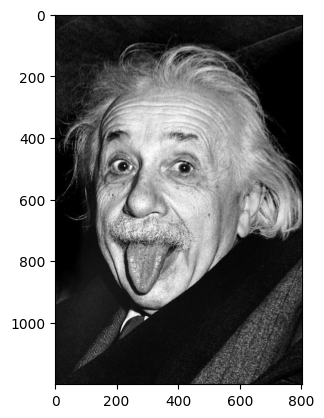

In [133]:
ein = plt.imread('einstein.jpg')
plt.imshow(ein, cmap='grey')
print(ein.shape)

(1, 1360, 1360)


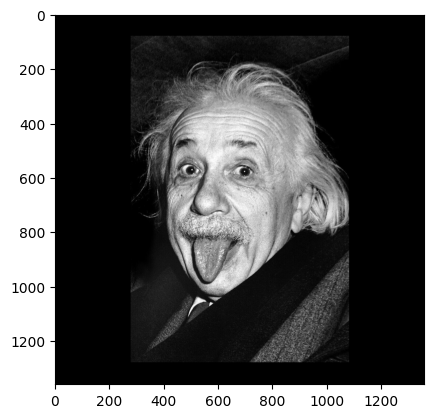

In [134]:
canvas_size = (1360,1360)

canvas = place_image_on_canvas(ein, canvas_size, position="center", scale=1)


canvas = normalize(canvas)

canvas = np.expand_dims(canvas, axis=0)
print(canvas.shape)
# print(canvas.transpose(2,1,0).shape)
# Display the result
plt.imshow(canvas.transpose(1,2,0),cmap='gray')
# plt.axis('off')
plt.show()


In [135]:
YI = np.array(range(canvas.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XI = np.array(range(canvas.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
YJ = np.array(range(J.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
XJ = np.array(range(J.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.

# get extent of ima


extentJ = extent_from_x((YJ,XJ))
extentI = extent_from_x((YI,XI))

C:\Users\jerry\AppData\Local\Temp\ipykernel_8976\1571862493.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
C:\Users\jerry\AppData\Local\Temp\ipykernel_8976\1571862493.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = torch.tensor(XJ)


Text(0.5, 1.0, 'Deformed')

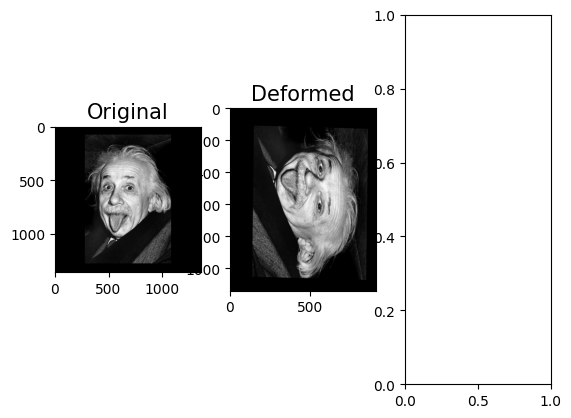

In [139]:
# compute initial affine transformation from points
AI= transform_image_source_with_A(A, [YI,XI], canvas, [YJ,XJ])

#switch tensor from cuda to cpu for plotting with numpy
if AI.is_cuda:
    AI = AI.cpu()

fig,ax = plt.subplots(1,3)

ax[0].imshow(canvas.transpose(1,2,0), cmap='gray', extent=extentI)
ax[1].imshow((AI.permute(1,2,0).squeeze()), cmap='gray', extent=extentJ)


ax[0].set_title('Original', fontsize=15)
ax[1].set_title('Deformed', fontsize=15)

In [137]:
# Save the tensor as a .bmp file
save_tensor_as_bmp(AI, 'DMD-Pattern_Einstein.bmp')

### Figure Generation for meeting with JT

In [20]:
from nd2reader import ND2Reader
import numpy as np
import matplotlib.pyplot as plt

# Function to open and load .nd2 files
def load_nd2(file_path):
    # Open the ND2 file
    with ND2Reader(file_path) as images:
        # Access image metadata and the number of frames
        print(f"Number of frames: {len(images)}")
        print(f"Image dimensions: {images.sizes}")
        
        # Load the first frame as an example
        first_frame = np.array(images[0])
        
        # Display the first frame using matplotlib
        plt.imshow(first_frame, cmap='gray')
        plt.title("First Frame")
        plt.show()

        return first_frame

# Example usage
file_path_diplo = r"T:\Jerry\01_projects\EJW001_Communicating-With-Polygon\04_affine\diplo_on_camera.nd2"
file_path_einstein = r"T:\Jerry\01_projects\EJW001_Communicating-With-Polygon\04_affine\einstein_on_camera.nd2"
diplo_on_cam = load_nd2(file_path_diplo)
ein_on_cam = load_nd2(file_path_einstein)


ModuleNotFoundError: No module named 'nd2reader'

In [146]:
ein_bmp = plt.imread(r"T:\Jerry\01_projects\EJW001_Communicating-With-Polygon\04_affine\DMD-Pattern_Einstein.bmp")
diplo_bmp = plt.imread(r"T:\Jerry\01_projects\EJW001_Communicating-With-Polygon\04_affine\DMD-Pattern_Diplodocus.bmp")

In [ ]:
import matplotlib.pyplot as plt

def plot_three_images(image1, image2, image3, title1='Image 1', title2='Image 2', title3='Image 3'):
    """
    Plots three images in a single row with three subplots.

    Parameters:
    - image1: The first image (2D array or image data).
    - image2: The second image (2D array or image data).
    - image3: The third image (2D array or image data).
    - title1: Title for the first image.
    - title2: Title for the second image.
    - title3: Title for the third image.
    """
    # Create a figure and subplots (1 row, 3 columns)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first image
    ax1.imshow(image1, cmap='gray')
    ax1.set_title(title1)
    ax1.axis('off')  # Turn off axis labels/ticks for cleaner view

    # Plot the second image
    ax2.imshow(image2, cmap='gray')
    ax2.set_title(title2)
    ax2.axis('off')

    # Plot the third image
    ax3.imshow(image3, cmap='gray')
    ax3.set_title(title3)
    ax3.axis('off')

    # Adjust the layout to prevent overlap
    plt.tight_layout()

    # Display the images
    plt.show()

# Example usage
# image1, image2, image3 are 2D arrays representing images
# plot_three_images(image1, image2, image3, "First Image", "Second Image", "Third Image")
